# Initialization

In [1]:
%load_ext autoreload
%autoreload 2
import sys, warnings, time, numpy, yaml, pandas, logging, random
from pathlib import Path
sys.path.append("../src/") # go to parent dir
from data_access import get_X, get_y, get_train_test
from models.factory import ModelFactory
warnings.filterwarnings('ignore')
with open('../confs/logs.yaml', 'rt') as f:
    config = yaml.safe_load(f.read())
logging.config.dictConfig(config)

In [2]:
X_train, y_train, X_test, y_test, target = get_train_test(train_size=0.8, random_state=42)
train_scores = get_y()
test_data = get_X('test')

In [3]:
def eval_model(model, save_model=False, X=X_test):
    start = time.time()
    model.fit()
    score = model.evaluate(X)
    end = time.time()
    logging.debug(f'{model.name}={score} in {numpy.round((end-start), 2)}s')
    if save_model:
        model.save(test_data)
    return {'name': model.name, 'score': score, 'time': numpy.round((end-start), 2)}

In [4]:
%load_ext autoreload
%autoreload 2
def eval_model_for_name(name, X=X_train, y=y_train):
    with open('../confs/models.yaml', 'r') as file:
        configurations = yaml.safe_load(file)
    factory = ModelFactory(configurations, X, y, train_scores)
    model = factory.get_model(name)
    return eval_model(model)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_features(name = 'ada_boost'):
    with open('../confs/models.yaml', 'r') as file:
        configurations = yaml.safe_load(file)
    factory = ModelFactory(configurations, X_train, y_train, train_scores)
    model = factory.get_model(name)
    eval_model(model)
    df_importances = model.get_feature_importances()
    return list(df_importances['feature'])

In [6]:
default_features=get_features('ada_boost')

In [7]:
def test_features(name = 'xgb_gblinear', save=True, features=default_features):
    with open('../confs/models.yaml', 'r') as file:
        configurations = yaml.safe_load(file)
    lines = []
    best_score = 0
    selected_features = []
    for i in range(1, len(features)):
        sub_features = selected_features.copy()
        feature = features[i-1]
        sub_features.append(feature)
        # sub_features = features[:i]
        factory = ModelFactory(configurations, X_train[sub_features], y_train, train_scores)
        model = factory.get_model(name)
        model.name = f'{name}_{i}'
        line = eval_model(model,X=X_test[sub_features])
        line['nbr_features'] = len(sub_features)
        line['model'] = name
        line['feature'] = feature
        line['features'] = sub_features
        lines.append(line)
        if best_score < line['score']:
            selected_features.append(line['feature'])
            best_score = line['score']
    df = pandas.DataFrame(lines)
    if save:
        df.to_csv(f'../data/output/features/{name}.csv')
    logging.info(f'Features selected for score {name} - {best_score}: {len(selected_features)}, {selected_features}')
    return df

In [8]:
def get_row_by_features(filename, columns=X_train.columns):
    row_by_features = {}
    if Path(filename).exists():
        df = pandas.read_csv(f'{filename}')
        for index, row in df.iterrows():
            line = {
                'name': row['name'],
                'score': row['score'],
                'time':  row['time'],
                'model': row['model'],
                'size': row['size'],
                'features': row['features']
                }
            row_by_features[row['features']] = line
    return row_by_features
def random_features(name = 'xgb_gblinear', size=10, nbr=20, save=False, root_folder='../data/output/random_features/'):
    with open('../confs/models.yaml', 'r') as file:
        configurations = yaml.safe_load(file)
    filename=f'{root_folder}/{name}.csv'
    row_by_features = get_row_by_features(filename)
    lines = list(row_by_features.values())
    best_score = 0
    selected_features = []
    features = list(X_train.columns)
    start = time.time()
    for i in range(1, nbr):
        sub_features = random.sample(features, size)
        if str(sub_features) in row_by_features:
            logging.info(f'skip {sub_features}')
            continue
        # sub_features = features[:i]
        factory = ModelFactory(configurations, X_train[sub_features], y_train, train_scores)
        model = factory.get_model(name)
        model.name = f'{name}_{i}'
        line = eval_model(model,X=X_test[sub_features])
        line['model'] = name
        line['size'] = size
        line['features'] = str(sub_features)

        
        lines.append(line)
        if best_score < line['score']:
            selected_features=sub_features
            best_score = line['score']
    end = time.time()
    df = pandas.DataFrame(lines)
    df=df.sort_values(by=['score'], ascending=False)
    # df .reset_index(inplace=True)
    if save:
        df.to_csv(filename, index=False)
    logging.info(f'{name} - {best_score}: {len(selected_features)}, {selected_features}')
    return df

In [9]:
def plot_features(folder = '../data/output/features/'):
   import os, pandas
   df = None
   for filename in os.listdir(folder):
      # if not os.path.isfile(filename): continue
      model = filename.split('.')[0]
      df_tmp = pandas.read_csv(f'{folder}{filename}')
      df_tmp[model] = df_tmp['score']
      if df is None:
         df = df_tmp[[model]]
      else:
         df[model] = df_tmp[[model]]
   df.plot.line()

# Feature importances

In [14]:
sizes=list(range(5, 20))
nbr=200
batch_sizes=list(range(5, 10))

save=True
names= ['random_forest', 'catboost', 'gradient_boosting', 'ada_boost', 'lightgbm', 'extra_trees', 'hist_gradient_boosting', 'mlp', 
        'xgb_gblinear', 'xgb_classifier', 'xgb_gbtree']
# names= ['random_forest', 'ada_boost', 'xgb_gblinear', 'xgb_classifier', 'xgb_gbtree']
names= ['ada_boost', 'xgb_gblinear']
# names= ['ada_boost']
# names= ['xgb_gblinear']
for name in names:
    for size in sizes:
        random_features(name, size, nbr, True)
plot_features('../data/output/random_features/')
# ['TEAM_PASSES_season_sum', 'TEAM_DANGEROUS_ATTACKS_season_std', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_GAME_WON_season_sum', 'TEAM_INJURIES_5_last_match_sum', 'TEAM_DANGEROUS_ATTACKS_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_std', 'TEAM_GAME_LOST_season_sum']

2024-02-21 19:27:32,301 - root- INFO - ada_boost - 0.497: 5, ['TEAM_SHOTS_TOTAL_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_GAME_WON_season_sum', 'TEAM_GAME_DRAW_5_last_match_average', 'TEAM_FOULS_season_average']
2024-02-21 19:28:36,129 - root- INFO - ada_boost - 0.4965: 6, ['TEAM_SHOTS_OFF_TARGET_season_std', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_GAME_WON_5_last_match_sum', 'TEAM_PASSES_5_last_match_average', 'TEAM_BALL_POSSESSION_5_last_match_std', 'TEAM_SUBSTITUTIONS_season_sum']
2024-02-21 19:29:42,608 - root- INFO - ada_boost - 0.4941: 7, ['TEAM_GAME_WON_season_sum', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_SHOTS_OFF_TARGET_season_std', 'TEAM_GOALS_season_std', 'TEAM_SAVES_season_std', 'TEAM_FOULS_5_last_match_std']
2024-02-21 19:30:52,058 - root- INFO - ada_boost - 0.4953: 8, ['TEAM_SHOTS_OUTSIDEBOX_season_std', 'TEAM_GAME_WON_season_sum', 'TEAM_PENALTIES_season_average', 'TEAM_SHOTS_TOTAL_5_last_match_sum', 'TEAM

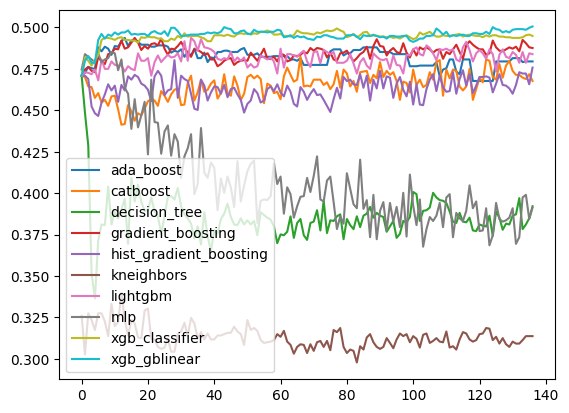

In [11]:
plot_features('../data/output/all_features/')

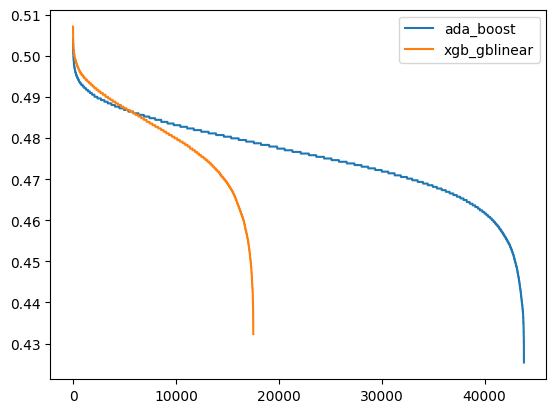

In [12]:
plot_features('../data/output/random_features/')

In [13]:
folder = '../data/output/random_features/'
df = None
names= ['ada_boost', 'xgb_gblinear']
for name in names:
    df = pandas.read_csv(f'{folder}{name}.csv')
    print(name)
    print(df['score'].describe())

ada_boost
count    43829.000000
mean         0.475617
std          0.010082
min          0.425400
25%          0.470100
50%          0.476600
75%          0.482700
max          0.503900
Name: score, dtype: float64
xgb_gblinear
count    17523.000000
mean         0.480287
std          0.011053
min          0.432300
25%          0.474200
50%          0.481900
75%          0.488000
max          0.507100
Name: score, dtype: float64
